In [20]:
using Pkg; Pkg.activate("/Users/deszoeks/Projects/ASTRAL/lidar/lidar2019")

using Revise
using Dates

# using CSV
# using DataFrames
using DelimitedFiles
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar/lidar2019`


In [2]:
# example featuring a Dict

#=
function read_streamlinexr(file::String, nrange::Int)
    # Read data from file skipping header
    x = CSV.read(file, DataFrames.header=false, DataFrame, limit=10000, footerskip=4)

    # get ray time and angles
    # Decimal time (hours)  Azimuth (degrees)  Elevation (degrees) Pitch (degrees) Roll (degrees)
    timeangles = x[1:nrange:end, :]
    a = Dict(
        :dechour => timeangles[!, 1],
        :azimuth => timeangles[!, 2],
        :elevation => timeangles[!, 3],
        :pitch => timeangles[!, 4],
        :roll => timeangles[!, 5]
    )

    nt = length(h[:dechour])

    # get ray data
    idata = mod.(0:size(x, 1)-1, nrange+1) .> 0
    a[:rangegate ] = reshape(x[idata, 1], (nrange, nt))
    a[:dopplervel] = reshape(x[idata, 2], (nrange, nt))
    a[:intensity ] = reshape(x[idata, 3], (nrange, nt))
    a[:beta      ] = reshape(x[idata, 4], (nrange, nt))

    return a
end
=#

In [21]:
# functions for reading hpl files

"""
header = read_streamlinexr_head(file_path)
Read the Halo Photonics StreamLineXR .hpl file header.
"""
function read_streamlinexr_head(file_path)
    # put the header in a Dict
    h = Dict(
        :nlines => countlines(file_path),
        # variables defined outside the do block, defaults will be overwritten.
        :ngates => Int32(104),
        :gatelength => 30.0,
        :nrays => Int32(1), # or 40
        :start_time => DateTime(2024,5,2,10,0,0),
        :vel_resolution => 0.0380,
        :headr1 => split("time Azimuth Elevation Pitch Roll"),
        :units1 => split("hours degrees degrees degrees degrees"),
        :headr2 => ["Range Gate", "Doppler", "Intensity", "Beta"],
        :units2 => ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
    )

    # open and read the file header, updating the header dict a
    open(file_path) do file
        for _ in 1:2 # skip lines
            readline(file)
        end

        # read number of gates from line 3
        h[:ngates] = parse(Int32, last(split(readline(file)))) # 104
        # read gate length from line 4
        h[:gatelength] = parse(Float64, last(split(readline(file))))
        for _ in 5:6 # skip
            readline(file)
        end

        # read number of rays from line 7
        h[:nrays] = parse(Int32, last(split(readline(file)))) # 1 for Stare or 40 for User
        for _ in 8:9 # skip
            readline(file)
        end

        # read start time from line 10
        tl = split(readline(file))
        h[:start_time] = DateTime(tl[end-1]*tl[end], "yyyymmddHH:MM:SS.ss")
        # read velocity resolution (m/s) line 11
        h[:vel_resolution] = parse(Float64, last(split(readline(file))))
        readline(file) # skip line 12
        # read header 1 from line 13
        hdrln = split(readline(file))[5:end]
        h[:headr1] = hdrln[1:2:end]
        h[:units1] = hdrln[2:2:end]
        readline(file) # skip line 14
        # read header 2 from line 15
        hdrln = split(readline(file))[4:end] # but don't parse it
        h[:headr2] = ["Range Gate", "Doppler", "Intensity", "Beta"]
        h[:units2] = ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
        # for _ in 16:17 # skip
        #     readline(file)
        # end
    end

    return h
end

"""
modifying read_streamlinexr_data!(file_path, header, beams)
Read data and fill in the beams.
"""
function read_streamlinexr_data!(file_path, h, beams)
    # use header information in h
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-17) / (1+ngates)) # = nrays*ntimes
    beam_timeangles = zeros(nbeams, 5)
    beam_velrad = zeros(nbeams, ngates, 4)

    # for User wind profiles beam <--> VAD ray
    # for Stare beam <--> time

    # open and read the file
    open(file_path) do file
        for _ in 1:17 # skip 17 header lines
            readline(file)
        end

        # now read data
        for ibeam = 1:nbeams
            # beam described by a batch of 1+ngates lines
            # Read the beam parameter line
            line = readline(file)
            beam_timeangles[ibeam,:] .= parse.(Float64, split(line))
            # Read each gate in the beam
            for igate = 1:ngates
                line = readline(file)
                beam_velrad[ibeam, igate,:] .= parse.(Float64, split(line))
            end
        end
    end # close the file

    # parse the variables into the dict beams
    # by beam
    beams[:time     ] .= beam_timeangles[:,1] # decimal hours
    beams[:azimuth  ] .= beam_timeangles[:,2] # degrees
    beams[:elevangle] .= beam_timeangles[:,3] # degrees
    beams[:pitch    ] .= beam_timeangles[:,4]
    beams[:roll     ] .= beam_timeangles[:,5]
    # by gate
    beams[:height   ] .= (beam_velrad[1,:,1].+0.5) .* h[:gatelength] # center of gate, assumes same for all beams

    # dependent variables (beam, gate)
    beams[:dopplervel] .= beam_velrad[:,:,2] # m/s
    beams[:intensity ] .= beam_velrad[:,:,3] # SNR + 1
    beams[:beta      ] .= beam_velrad[:,:,4] # m-1 sr-1  backscatter?
end

"""
beams, h = read_streamlinexr(file_path)
Read the Photonics StreamLineXR .hpl file data and header.
"""
function read_streamlinexr(file_path)
    # use header information in h
    h = read_streamlinexr_head(file_path)
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-17) / (1+ngates)) # = nrays*ntimes
    # initialize a beams Dict
    beams = Dict(
        :time      => Vector{Union{Float32,Missing}}(missing, nbeams), # decimal hours
        :azimuth   => Vector{Union{Float32,Missing}}(missing, nbeams), # degrees
        :elevangle => Vector{Union{Float32,Missing}}(missing, nbeams),
        :pitch     => Vector{Union{Float32,Missing}}(missing, nbeams),
        :roll      => Vector{Union{Float32,Missing}}(missing, nbeams),

        :height    => Vector{Union{Float32,Missing}}(missing, ngates), # center of gate

        # dependent variables (beam, gate)
        :dopplervel => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # m/s
        :intensity  => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # SNR + 1
        :beta       => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates) # m-1 sr-1  backscatter?
        )

    # read file and fill beams with data
    read_streamlinexr_data!(file_path, h, beams)
    return beams, h
end


read_streamlinexr

In [22]:
# read procedurally

#=
file_path = "./data/Stare_06_20190710_06.hpl"
nlines = countlines(file_path)

file = open(file_path)
for _ in 1:2 # skip lines
    readline(file)
end

# read number of gates from line 3
ngates = parse(Int32, last(split(readline(file)))) # 104
# read gate length from line 4
gatelength = parse(Float64, last(split(readline(file))))
for _ in 5:6 # skip
    readline(file)
end

# read number of rays from line 7
nrays = parse(Int32, last(split(readline(file)))) # 1 for Stare or 40 for User
for _ in 8:9 # skip
    readline(file)
end

# read start time from line 10
tl = split(readline(file))
start_time = DateTime(tl[end-1]*tl[end], "yyyymmddHH:MM:SS.ss")
# read velocity resolution (m/s) line 11
vel_resolution = parse(Float64, last(split(readline(file))))
readline(file) # skip line 12
# read header 1 from line 13
hdrln = split(readline(file))[5:end]
headr1 = hdrln[1:2:end]
units1 = hdrln[2:2:end]
readline(file) # skip line 14
# read header 2 from line 15
hdrln = split(readline(file))[4:end] # but don't parse it
headr2 = ["Range Gate", "Doppler", "Intensity", "Beta"]
units2 = ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
for _ in 16:17 # skip
    readline(file)
end

# now DATA
# beams could be rays or times
nbeams = round(Int, (nlines-17) / (1+ngates)) # = nrays*ntimes
data1 = zeros(nbeams, 5)
data2 = zeros(nbeams, ngates, 4)
# for User wind profiles beam <--> VAD ray
# for Stare beam <--> time
for ibeam = 1:nbeams
    # beam described by a batch of 1+ngates lines
    # Read the beam parameter line
    line = readline(file)
    data1[ibeam,:] .= parse.(Float64, split(line))
    # Read each gate in the beam
    for igate = 1:ngates
        line = readline(file)
        data2[ibeam, igate,:] .= parse.(Float64, split(line))
    end
end

# parse the variables
# beam
time      = data1[:,1] # decimal hours
azimuth   = data1[:,2] # degrees
elevangle = data1[:,3] # degrees
pitch     = data1[:,4]
roll      = data1[:,5]
# gate
height = (data2[1,:,1].+0.5) .* gatelength # center of gate

# dependent variables (beam, gate)
dopplervel = data2[:,:,2] # m/s
intensity  = data2[:,:,3] # SNR + 1
beta       = data2[:,:,4] # m-1 sr-1  backscatter?
=#

In [24]:
file_path = "./data/Stare_06_20190710_06.hpl"

beams, header = read_streamlinexr(file_path)

(Dict{Symbol, Array{Union{Missing, Float32}}}(:time => [6.0441f0, 6.0442443f0, 6.044389f0, 6.044536f0, 6.0446806f0, 6.044825f0, 6.0449696f0, 6.045114f0, 6.0452585f0, 6.0454054f0  …  6.9986196f0, 6.998764f0, 6.9989085f0, 6.999053f0, 6.999197f0, 6.9993415f0, 6.999486f0, 6.9996305f0, 6.999772f0, 6.9999166f0], :dopplervel => [0.0618f0 -0.6978f0 … 1.999f0 -16.613f0; 0.0239f0 -0.7358f0 … 1.5812f0 1.2014f0; … ; -0.0141f0 -0.8118f0 … -0.7358f0 -0.356f0; 0.0239f0 -0.6978f0 … -16.0053f0 -11.4852f0], :roll => [-1.62f0, -0.4f0, 2.66f0, 2.66f0, 4.18f0, 2.86f0, 3.06f0, 0.92f0, -1.11f0, -0.71f0  …  -1.01f0, -0.81f0, -0.4f0, 0.62f0, 1.43f0, 2.66f0, 4.39f0, 2.15f0, 0.72f0, 0.62f0], :beta => [5.322493f-7 -3.953876f-7 … 4.406489f-6 4.766293f-6; 1.021625f-6 -1.134597f-6 … -2.307283f-7 5.319702f-7; … ; 8.483945f-7 -1.415166f-6 … 3.653108f-6 2.427004f-6; 5.477318f-8 -2.07776f-8 … 7.689105f-7 1.08416f-6], :elevangle => [90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0, 90.0f0  …  90.0f0

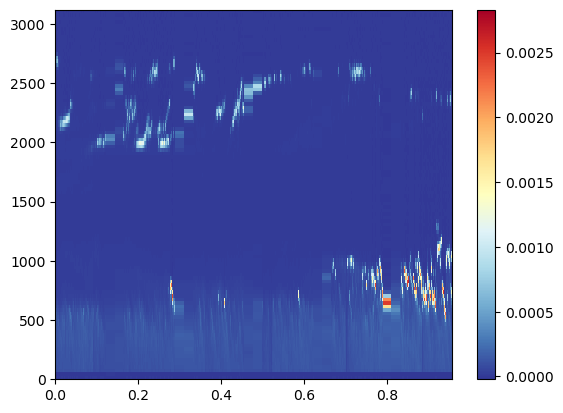

PyObject <matplotlib.colorbar.Colorbar object at 0x3703e3880>

In [42]:
pd = permutedims

pcolormesh((beams[:time].-beams[:time][1]),
            beams[:height],
            pd(beams[:intensity]),
            cmap=ColorMap("RdYlBu_r"),
            vmax=35.0, vmin=1.0 )
colorbar()

clf()
pcolormesh((beams[:time].-beams[:time][1]),
            beams[:height],
            pd(beams[:dopplervel]),
            cmap=ColorMap("RdYlBu_r"),
            vmin=-5, vmax=5 )
colorbar()

clf()
pcolormesh((beams[:time].-beams[:time][1]),
            beams[:height],
            pd(beams[:beta]),
            cmap=ColorMap("RdYlBu_r"),)
#           vmin=-5, vmax=5 )
colorbar()

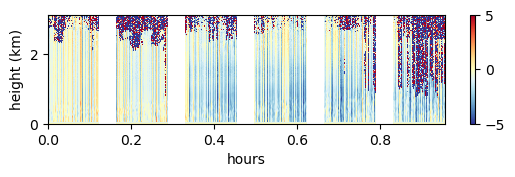

PyObject Text(24.000000000000007, 0.5, 'height (km)')

In [77]:
plot(beams[:time].-beams[:time][1])

"find start and end indices of continuous time chunks"
function index_chunks(time, dt=1/60)
    fi = findall( diff(time) .> dt ) # last index of continuous chunks
    sti = [1; fi.+1]
    eni = [fi; length(time)]
    return sti, eni
end

sti,eni = index_chunks(beams[:time])

# plot(fi, (beams[:time].-beams[:time][1])[fi])
# plot(sti, beams[:time][sti].-beams[:time][1], color="g", marker="o", linestyle="none")
# plot(eni, beams[:time][eni].-beams[:time][1], color="r", marker="x", linestyle="none")

function plot_stares(time, height, dopplervel)
    sti,eni = index_chunks(beams[:time])
    for rng in range.(sti, eni)
        pcolormesh(time[rng], height, pd(dopplervel[rng,:]),
            cmap=ColorMap("RdYlBu_r"),
            vmin=-5, vmax=5 )
    end
end

clf()
subplot(3,1,1)
plot_stares(beams[:time].-beams[:time][1], beams[:height]/1e3, beams[:dopplervel])
colorbar()
xlabel("hours")
ylabel("height (km)")